In [ ]:
!pip install transformers #installing because we want to use pre_trained models, both from huggingface and our own models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import get_linear_schedule_with_warmup
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/ESC324projectdrive/dav/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Simplify the code by creating a function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the pickle files using the function
neg_list_processed = load_pickle(base_dir + 'neg_list_processed.pickle')
het_list_processed = load_pickle(base_dir + 'het_list_processed.pickle')
homo_list_processed = load_pickle(base_dir + 'homo_list_processed.pickle')
rel_freq = load_pickle(base_dir + 'tag_dict.pickle')

In [ ]:
print(rel_freq)

{'': 0.0003436426116838488, "''": 0.0003436426116838488, ',': 0.0003436426116838488, '-LRB-': 0.0003436426116838488, '-RRB-': 0.0003436426116838488, '.': 0.0003436426116838488, ':': 0.0003436426116838488, 'CC': 0.0003436426116838488, 'CD': 0.0010309278350515464, 'DT': 0.0003436426116838488, 'EX': 0.0003436426116838488, 'FW': 0.0006872852233676976, 'HYPH': 0.0003436426116838488, 'IN': 0.0024054982817869417, 'JJ': 0.11134020618556702, 'JJR': 0.0013745704467353953, 'JJS': 0.0013745704467353953, 'LS': 0.0003436426116838488, 'MD': 0.0013745704467353953, 'NFP': 0.0003436426116838488, 'NN': 0.3518900343642612, 'NNP': 0.07835051546391752, 'NNPS': 0.0013745704467353953, 'NNS': 0.09725085910652921, 'PDT': 0.0003436426116838488, 'POS': 0.0003436426116838488, 'PRP': 0.0006872852233676976, 'PRP$': 0.0003436426116838488, 'RB': 0.06632302405498282, 'RBR': 0.0006872852233676976, 'RBS': 0.0003436426116838488, 'RP': 0.001718213058419244, 'TO': 0.0003436426116838488, 'UH': 0.002061855670103093, 'VB': 0.0

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

mega_list = homo_list_processed + het_list_processed
#shuffling the list
random.shuffle(mega_list)


In [ ]:
#mega_list is a giant list where each sublist of the following format:
#[['in/IN', 'the/DT', 'room/NN', 'the/DT', 'curtain/NNS', 'be/VBD', 'draw/VBN', ',/,', 'but/CC', 'the/DT', 'rest/NN', 'of/IN', 'the/DT', 'furniture/NN', 'be/VBD', 'real/JJ', './.'], ['In', 'the', 'room', 'the', 'curtains', 'were', 'drawn', ',', 'but', 'the', 'rest', 'of', 'the', 'furniture', 'was', 'real', '.'], ['draw/VBN']]. the first subsublist in the sublist is contains words in a sentence that have been POS tagged, second subsublist containts the original sentence, and third subsublist contains the pun word that has been POS tagged. Write code to tokenize this data, and fine tune a pretrained RoBERTa model to predict location of puns

input_sentences = [sublist[1] for sublist in mega_list]
pos_sentences = [sublist[0] for sublist in mega_list]
pun_words = [sublist[2][0] for sublist in mega_list]

#calculating the max len for padding the inputs
max_len = 0
longest_joke = ""
for sentence in input_sentences:
  if len(sentence) > max_len:
    max_len = len(sentence)
    longest_joke = " ".join(sentence) 
print("Largest sentence in dataset has lenght = ", max_len)
print("This joke is:\n", longest_joke)

#creating an array of heuristic based on rel_freq mapping for each tag in dataset
rel_freq_heuristic = []
for sentence in pos_sentences:
  temp_heuristic = []
  for word in sentence:
    temp_heuristic.append(rel_freq.get(word.split("/")[1], 0))
  temp_heuristic += [0]*(max_len - len(temp_heuristic))
  rel_freq_heuristic.append(temp_heuristic)
rel_freq_heuristic = torch.tensor(rel_freq_heuristic)

input_ids = []
attention_masks = []
labels = []

for sentence, pun_word, pos_sentence in zip(input_sentences, pun_words, pos_sentences):
    encoded_data = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length = max_len, #we are padding all sentences to a max_len elements (words + punction)
        pad_to_max_length = True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_data['input_ids'])
    attention_masks.append(encoded_data['attention_mask'])
    labels.append(pos_sentence.index(pun_word))

#checking if the label index is within the range of max_len, else set it to the first word in the sentence
labels = [label if label < max_len else 0 for label in labels]
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Largest sentence in dataset has lenght =  77
This joke is:
 The celebration of the royal wedding progressed well into the night . As he stumbled outside to await his ride home one inebriated nobleman , attracted by the bright lights , made his way to the theater district and sat down below one of the brightly illuminated theater signs to await his car . The driver , unfamiliar with both the nobleman and the area , was instructed to look for a well - lit marquis .


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
#splitting the data into train, validation and test sets
train_inputs, val_test_inputs, train_labels, val_test_labels, train_masks, val_test_masks, train_freq_heuristic, val_test_freq_heuristic = train_test_split(input_ids, labels, attention_masks, rel_freq_heuristic, random_state = seed, test_size = 0.3)
val_inputs, test_inputs, val_labels, test_labels, val_masks, test_masks, val_freq_heuristic, test_freq_heuristic = train_test_split(val_test_inputs, val_test_labels, val_test_masks, val_test_freq_heuristic, random_state = seed, test_size = 0.5)

#creating DataLoader
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_freq_heuristic)
train_dataloader = DataLoader(train_data, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels, val_freq_heuristic)
val_dataloader = DataLoader(val_data, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels, test_freq_heuristic)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

126
27
27


In [ ]:
#writing the dataloaders to a pickle file so that we can use them later while using ensembles
with open(base_dir + 'dataloaders_roberta.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((train_dataloader, val_dataloader, test_dataloader), f)
#close file
f.close()

In [ ]:
#function to calculate accuracy of the model for a given batch of data
def accuracy(model_output, ground_truth_labels, rel_freq_heuristic):
  model_output = model_output.detach().cpu() * rel_freq_heuristic.cpu()
  model_output = torch.argmax(model_output, dim=1)
  model_output = np.array(model_output)
  ground_truth_labels = np.array(ground_truth_labels.detach().cpu())

  #checking how many values in model_output are equal to their corresponding values in ground_truth_labels
  num_correct = np.sum(model_output == ground_truth_labels)
  accuracy_val = num_correct / len(ground_truth_labels)
  return accuracy_val

In [ ]:
# Fine-tune the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels = max_len)

#continue training of same model
# model = transformers.RobertaForSequenceClassification.from_pretrained(base_dir + 'roberta_model1_10_epochs')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(["Using CPU", "Using Cuda"][int(torch.cuda.is_available())])
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.000007) #63.28% with 0.000007
epochs = 100
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Using Cuda


In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

save = 1 #set to 1 to save model after every 10 epochs of training
sliding_window_width = 15 #set to the width of sliding window to check of overfitting
epochs_trained = 0 #number of epochs the model has actually been trained for

#training loop
epochs_pre_trained = 0
for epoch in tqdm(range(epochs_pre_trained, epochs_pre_trained + epochs), desc = "Training", colour = "green"):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        #forward pass
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        #calculating accuracy for batch
        total_train_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

        #backward pass
        loss.backward()

        #updating parameters
        optimizer.step()
        scheduler.step()
        model.zero_grad()

        # Delete unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    #calculating training accuracy
    avg_train_acc = total_train_acc / len(train_dataloader)
    train_loss.append(avg_train_loss)
    train_acc.append(avg_train_acc)

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    for batch in val_dataloader:
        input_ids, attention_mask, labels, rel_freq_heuristic = batch
        input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            total_val_loss += loss.item()
            #calculating accuracy for batch
            total_val_acc += accuracy(outputs[1], labels, rel_freq_heuristic)
        
        #deleting unnecessary values to save memory
        del input_ids, attention_mask, labels, outputs, loss

    #calculating average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_acc = total_val_acc / len(val_dataloader)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)   

    print(f"\nEpoch {epoch}\n\tTraining Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}\n\tTraining Accuracy: {avg_train_acc}, Validation Accuracy: {avg_val_acc}")

    if (epoch + 1) % 10 == 0 and save:
        model.save_pretrained(base_dir + 'roberta_model_' + str(epoch + 1) + '_epochs')
    
    #early stopping
    epochs_trained = epoch + 1
    if epoch > sliding_window_width:
        window = val_loss[epoch - sliding_window_width: epoch]
        if all(val_loss[epoch] > x for x in window):
            print(f"\nEarly stopping at epoch {epoch} due to overfitting")
            model.save_pretrained(base_dir + 'roberta_model_' + str(epoch + 1) + '_epochs')
            break
    

Training:   1%|          | 1/100 [00:33<54:53, 33.27s/it]


Epoch 0
	Training Loss: 3.7811851009489996, Validation Loss: 3.2222397680635804
	Training Accuracy: 0.26537698412698413, Validation Accuracy: 0.28917378917378916


Training:   2%|▏         | 2/100 [01:04<52:28, 32.13s/it]


Epoch 1
	Training Loss: 2.9861651886077154, Validation Loss: 2.5924568617785417
	Training Accuracy: 0.33878968253968256, Validation Accuracy: 0.3823005698005698


Training:   3%|▎         | 3/100 [01:35<50:54, 31.49s/it]


Epoch 2
	Training Loss: 2.492459472209688, Validation Loss: 2.2752376838966653
	Training Accuracy: 0.41865079365079366, Validation Accuracy: 0.47204415954415957


Training:   4%|▍         | 4/100 [02:06<50:23, 31.49s/it]


Epoch 3
	Training Loss: 2.2012742682108803, Validation Loss: 2.0727731386820474
	Training Accuracy: 0.46378968253968256, Validation Accuracy: 0.5026709401709402


Training:   5%|▌         | 5/100 [02:37<49:39, 31.36s/it]


Epoch 4
	Training Loss: 2.038645034744626, Validation Loss: 1.9615321556727092
	Training Accuracy: 0.49007936507936506, Validation Accuracy: 0.5147792022792023


Training:   6%|▌         | 6/100 [03:09<49:00, 31.28s/it]


Epoch 5
	Training Loss: 1.8946011407034737, Validation Loss: 1.844255805015564
	Training Accuracy: 0.5069444444444444, Validation Accuracy: 0.5350783475783476


Training:   7%|▋         | 7/100 [03:40<48:25, 31.25s/it]


Epoch 6
	Training Loss: 1.7854832713566129, Validation Loss: 1.8629426602964048
	Training Accuracy: 0.5248015873015873, Validation Accuracy: 0.5142450142450142


Training:   8%|▊         | 8/100 [04:11<47:53, 31.24s/it]


Epoch 7
	Training Loss: 1.6979182182796417, Validation Loss: 1.73902604315016
	Training Accuracy: 0.5342261904761905, Validation Accuracy: 0.542022792022792


Training:   9%|▉         | 9/100 [04:42<47:18, 31.19s/it]


Epoch 8
	Training Loss: 1.617267305888827, Validation Loss: 1.7626782832322296
	Training Accuracy: 0.5471230158730159, Validation Accuracy: 0.5605413105413105

Epoch 9
	Training Loss: 1.5491946680205209, Validation Loss: 1.7621060874727037
	Training Accuracy: 0.5491071428571429, Validation Accuracy: 0.5893874643874644


Training:  11%|█         | 11/100 [05:47<47:03, 31.73s/it]


Epoch 10
	Training Loss: 1.5094986591074202, Validation Loss: 1.6711675458484225
	Training Accuracy: 0.5545634920634921, Validation Accuracy: 0.5865384615384616


Training:  12%|█▏        | 12/100 [06:18<46:26, 31.66s/it]


Epoch 11
	Training Loss: 1.4134754926439315, Validation Loss: 1.611208271097254
	Training Accuracy: 0.5684523809523809, Validation Accuracy: 0.542022792022792


Training:  13%|█▎        | 13/100 [06:50<45:39, 31.49s/it]


Epoch 12
	Training Loss: 1.3610203791232336, Validation Loss: 1.6029809602984675
	Training Accuracy: 0.5793650793650794, Validation Accuracy: 0.5767450142450142


Training:  14%|█▍        | 14/100 [07:21<44:59, 31.39s/it]


Epoch 13
	Training Loss: 1.3065186256454104, Validation Loss: 1.5965212848451402
	Training Accuracy: 0.5932539682539683, Validation Accuracy: 0.5541310541310541


Training:  15%|█▌        | 15/100 [07:52<44:23, 31.34s/it]


Epoch 14
	Training Loss: 1.2455048371875097, Validation Loss: 1.5937626428074307
	Training Accuracy: 0.5902777777777778, Validation Accuracy: 0.5749643874643875


Training:  16%|█▌        | 16/100 [08:23<43:48, 31.29s/it]


Epoch 15
	Training Loss: 1.1814706770200578, Validation Loss: 1.560775425699022
	Training Accuracy: 0.5922619047619048, Validation Accuracy: 0.5981125356125355


Training:  17%|█▋        | 17/100 [08:54<43:13, 31.24s/it]


Epoch 16
	Training Loss: 1.1627045642761957, Validation Loss: 1.571858478917016
	Training Accuracy: 0.6140873015873016, Validation Accuracy: 0.5842236467236467


Training:  18%|█▊        | 18/100 [09:25<42:40, 31.22s/it]


Epoch 17
	Training Loss: 1.0917572814320762, Validation Loss: 1.5934588887073375
	Training Accuracy: 0.6398809523809523, Validation Accuracy: 0.5957977207977208


Training:  19%|█▉        | 19/100 [09:56<42:05, 31.18s/it]


Epoch 18
	Training Loss: 1.054992883214875, Validation Loss: 1.558484101736987
	Training Accuracy: 0.626984126984127, Validation Accuracy: 0.6120014245014245

Epoch 19
	Training Loss: 0.994492529640122, Validation Loss: 1.5796671068226849
	Training Accuracy: 0.6567460317460317, Validation Accuracy: 0.6096866096866096


Training:  21%|██        | 21/100 [11:01<41:33, 31.57s/it]


Epoch 20
	Training Loss: 0.9499098299041627, Validation Loss: 1.608574714925554
	Training Accuracy: 0.6567460317460317, Validation Accuracy: 0.6258903133903133


Training:  22%|██▏       | 22/100 [11:32<40:53, 31.45s/it]


Epoch 21
	Training Loss: 0.9233232284822162, Validation Loss: 1.5902135305934482
	Training Accuracy: 0.6736111111111112, Validation Accuracy: 0.6120014245014245


Training:  23%|██▎       | 23/100 [12:03<40:13, 31.34s/it]


Epoch 22
	Training Loss: 0.8722177057985275, Validation Loss: 1.5571886345192238
	Training Accuracy: 0.6845238095238095, Validation Accuracy: 0.6050569800569799


Training:  24%|██▍       | 24/100 [12:34<39:35, 31.26s/it]


Epoch 23
	Training Loss: 0.8402324351999495, Validation Loss: 1.6695517478165802
	Training Accuracy: 0.689484126984127, Validation Accuracy: 0.6166310541310541


Training:  25%|██▌       | 25/100 [13:06<39:15, 31.41s/it]


Epoch 24
	Training Loss: 0.7841546069534998, Validation Loss: 1.6526781585481432
	Training Accuracy: 0.7058531746031746, Validation Accuracy: 0.6333689458689459

Epoch 25
	Training Loss: 0.7805801547235913, Validation Loss: 1.6941355312312092
	Training Accuracy: 0.7118055555555556, Validation Accuracy: 0.6328347578347577

Early stopping at epoch 25 due to overfitting


Training:  25%|██▌       | 25/100 [13:39<40:57, 32.76s/it]


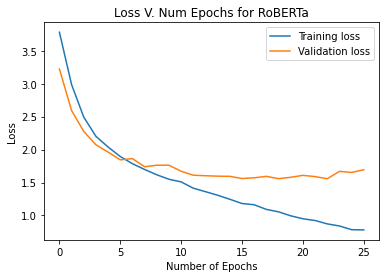

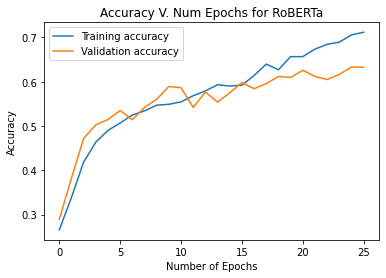

In [ ]:
#plotting the training and validation loss
plt.plot(list(range(epochs_trained)), train_loss, label = 'Training loss')
plt.plot(list(range(epochs_trained)), val_loss, label = 'Validation loss')
plt.title("Loss V. Num Epochs for RoBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plotting the training and validation accuracy
plt.plot(list(range(epochs_trained)), train_acc, label = 'Training accuracy')
plt.plot(list(range(epochs_trained)), val_acc, label = 'Validation accuracy')
plt.title("Accuracy V. Num Epochs for RoBERTa")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
#testing loop
model.eval()
total_test_loss = 0
total_test_acc = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels, rel_freq_heuristic = batch
    input_ids, attention_mask, labels, rel_freq_heuristic = input_ids.to(device), attention_mask.to(device), labels.to(device), rel_freq_heuristic.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_test_loss += loss.item()
        total_test_acc += accuracy(outputs[1], labels, rel_freq_heuristic)

    #deleting unnecessary values to save memory
    del input_ids, attention_mask, labels, outputs, loss

#calculating average test loss
avg_test_loss = total_test_loss / len(test_dataloader)
avg_test_acc = total_test_acc / len(test_dataloader)
print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_acc}")

Test Loss: 1.6196120977401733
Test Accuracy: 0.6322751322751323


In [ ]:
print(train_loss)
print(val_loss)
print(train_acc)
print(val_acc)

# Save the training and validation loss and accuracy to a pickle file
with open(base_dir + 'loss_acc_roberta.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((train_loss, val_loss, train_acc, val_acc), f)
#close file
f.close()

[3.7811851009489996, 2.9861651886077154, 2.492459472209688, 2.2012742682108803, 2.038645034744626, 1.8946011407034737, 1.7854832713566129, 1.6979182182796417, 1.617267305888827, 1.5491946680205209, 1.5094986591074202, 1.4134754926439315, 1.3610203791232336, 1.3065186256454104, 1.2455048371875097, 1.1814706770200578, 1.1627045642761957, 1.0917572814320762, 1.054992883214875, 0.994492529640122, 0.9499098299041627, 0.9233232284822162, 0.8722177057985275, 0.8402324351999495, 0.7841546069534998, 0.7805801547235913]
[3.2222397680635804, 2.5924568617785417, 2.2752376838966653, 2.0727731386820474, 1.9615321556727092, 1.844255805015564, 1.8629426602964048, 1.73902604315016, 1.7626782832322296, 1.7621060874727037, 1.6711675458484225, 1.611208271097254, 1.6029809602984675, 1.5965212848451402, 1.5937626428074307, 1.560775425699022, 1.571858478917016, 1.5934588887073375, 1.558484101736987, 1.5796671068226849, 1.608574714925554, 1.5902135305934482, 1.5571886345192238, 1.6695517478165802, 1.652678158